In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import MinMaxScaler

## Cargando datos

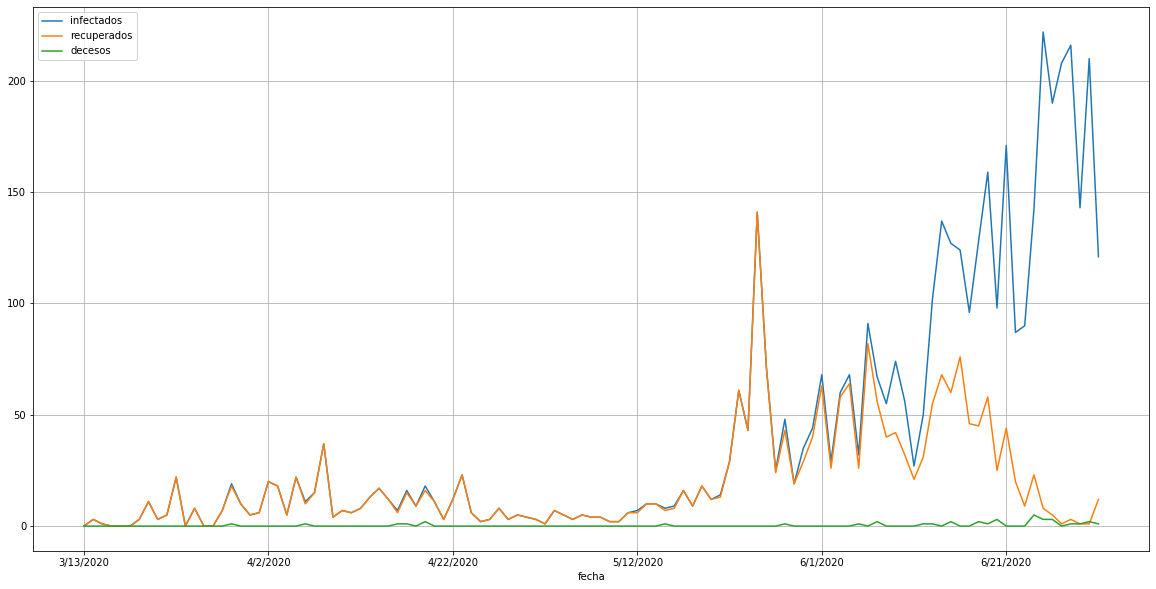

In [2]:
df = pd.read_csv("sird_constantes_dia_antioquia.csv")
df.plot(x='fecha', 
        y=['infectados', 'recuperados', 'decesos'], 
        kind='line', 
        figsize=(20, 10), 
        grid=True,
        legend=True,
        loglog=False
        )

In [3]:
df = df.drop(columns=['fecha', 'departamento'])
df.columns

Index(['susceptibles', 'infectados', 'recuperados', 'decesos',
       'cantidad_mayores_65', 'ipm', 'poblacion_total', 'personas_km2',
       'edad_promedio', 'promedio_morbilidades', 'susceptibles_t_1',
       'susceptibles_t_7', 'infectados_t_1', 'infectados_t_7', 'recuperados_1',
       'recuperados_t_7', 'decesos_t_1', 'decesos_t_7'],
      dtype='object')

In [4]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df)
df.loc[:,:] = scaled_values
df.head(10)

,susceptibles,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,promedio_morbilidades,susceptibles_t_1,susceptibles_t_7,infectados_t_1,infectados_t_7,recuperados_1,recuperados_t_7,decesos_t_1,decesos_t_7
0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1.000000,0.013514,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.999094,0.004505,0.007092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.013514,0.000000,0.021277,0.000000,0.0,0.0
3,0.998792,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999064,1.000000,0.004505,0.005848,0.007092,0.007092,0.0,0.0
4,0.998792,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998752,0.999619,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5,0.998792,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998752,0.999619,0.000000,0.017544,0.000000,0.021277,0.0,0.0
6,0.998792,0.013514,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998752,0.998474,0.000000,0.000000,0.000000,0.000000,0.0,0.0
7,0.997886,0.049550,0.078014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998752,0.998474,0.013514,0.000000,0.021277,0.000000,0.0,0.0
8,0.994565,0.013514,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997816,0.998474,0.049550,0.017544,0.078014,0.021277,0.0,0.0
9,0.993659,0.022523,0.035461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.994385,0.997330,0.013514,0.005848,0.021277,0.007092,0.0,0.0


In [5]:
def gradientBoostingRegressor(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    est = GradientBoostingRegressor(
                                    n_estimators=100,
                                    learning_rate=0.1,
                                    criterion="mse",
                                    warm_start=False
                                    )
    # Cross validation with 100 iterations to get smoother mean test and train score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    plot_learning_curve(est, X_train, y_train, cv=cv, n_jobs=4)
    est.fit(X_train, y_train)
    predicts = est.predict(X_test)
    
    print("Parameters:", est.get_params())
    print('Mean Absolute Error:', mean_absolute_error(y_test, predicts))
    print('Mean Squared Error:', mean_squared_error(y_test, predicts))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predicts)))
    print('Mean Absolute Percentage Error:', np.mean(np.abs((y_test,predicts))*100))
    print('R2:', est.score(X_test, y_test))#, r2_score(y_test, predicts))

    plot_importance(est, X)
    return est

In [6]:
def randomForestRegressor(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regr = RandomForestRegressor(
                                n_estimators=100, 
                                criterion="mse",
                                max_depth=100,
                                min_samples_leaf=2,
                                bootstrap=True,
                                warm_start=False
                                )
    # Cross validation with 100 iterations to get smoother mean test and train score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    plot_learning_curve(regr, X_train, y_train, cv=cv, n_jobs=4)
    regr.fit(X_train, y_train)
    predicts = regr.predict(X_test)
    
    print("Parameters:", regr.get_params())
    print('Mean Absolute Error:', mean_absolute_error(y_test, predicts))
    print('Mean Squared Error:', mean_squared_error(y_test, predicts))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predicts)))
    print('Mean Absolute Percentage Error:', np.mean(np.abs((y_test,predicts))*100))
    print('R2:', regr.score(X_test, y_test))#, r2_score(y_test, predicts))

    plot_importance(regr, X)
    return regr

In [7]:
def plot_importance(model, X):
    plt.barh(range(len(model.feature_importances_)), model.feature_importances_, align='center')
    x = X.columns
    x_pos = [i for i, _ in enumerate(x)]
    plt.yticks(x_pos, x)
    plt.xlabel("importance")
    plt.ylabel("variable")
    plt.title("feature importances")
    plt.show()

In [8]:
def plot_learning_curve(estimator, X, y, title='learning curve', ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

## Susceptibles

In [9]:
X_s = df[['recuperados_1', 'infectados_t_1', 'decesos_t_1', 'personas_km2', 'ipm', 'promedio_morbilidades', 'edad_promedio']]
y_s = df['susceptibles']

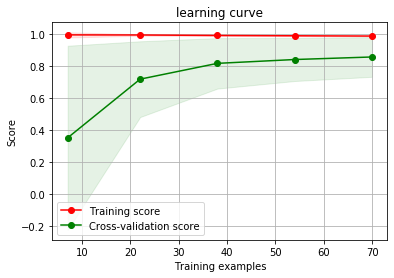

Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 0.07664138784623169
Mean Squared Error: 0.010432183344222858
Root Mean Squared Error: 0.10213806021372668
Mean Absolute Percentage Error: 80.89011236748574
R2: 0.7887846801929843


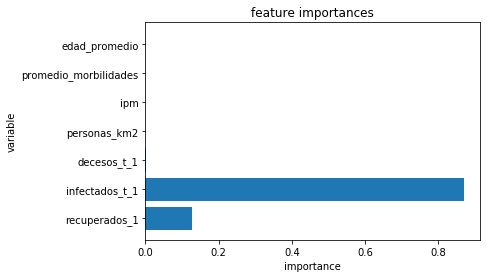

In [10]:
res_gb_s = gradientBoostingRegressor(X_s, y_s)

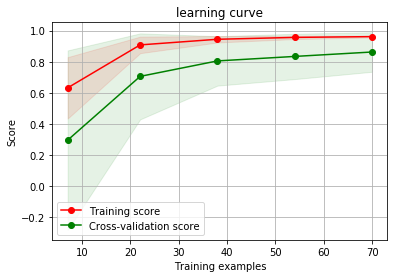

Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 0.07864499217045592
Mean Squared Error: 0.010811632975862205
Root Mean Squared Error: 0.10397900257197222
Mean Absolute Percentage Error: 80.31034055561834
R2: 0.7811021488711262


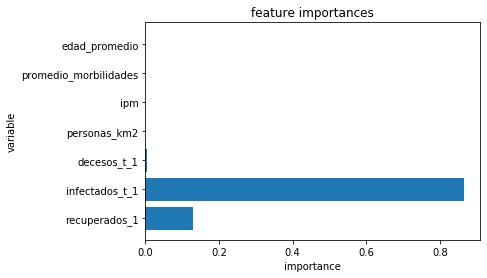

In [11]:
res_rf_s = randomForestRegressor(X_s, y_s)

## Infectados

In [12]:
X_i = df[['infectados_t_1', 'infectados_t_7', 'personas_km2', 'promedio_morbilidades', 'edad_promedio']]
y_i = df['infectados']

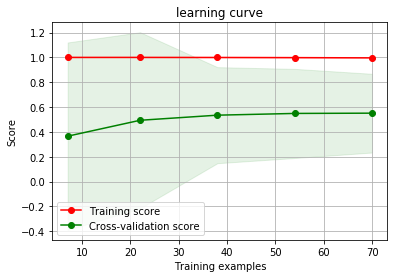

Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 0.04860333150352467
Mean Squared Error: 0.005422701086323415
Root Mean Squared Error: 0.07363899161669323
Mean Absolute Percentage Error: 13.94703544399971
R2: 0.8666364931656415


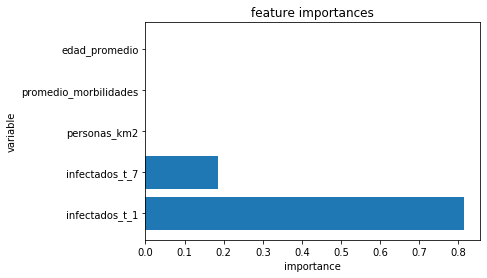

In [13]:
res_gb_i = gradientBoostingRegressor(X_i, y_i)

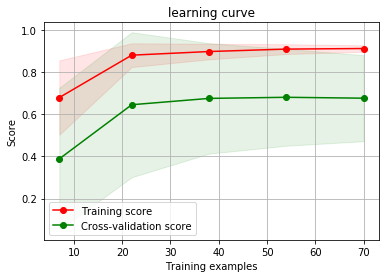

Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 0.06275955691716559
Mean Squared Error: 0.009932946955653362
Root Mean Squared Error: 0.09966417087225159
Mean Absolute Percentage Error: 13.894938300101343
R2: 0.7557135054803956


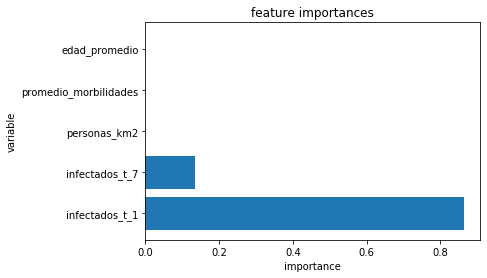

In [14]:
res_rf_i = randomForestRegressor(X_i, y_i)

## Recuperados

In [15]:
X_r = df[['recuperados_1', 'recuperados_t_7', 'personas_km2', 'promedio_morbilidades', 'edad_promedio']]
y_r = df['recuperados']

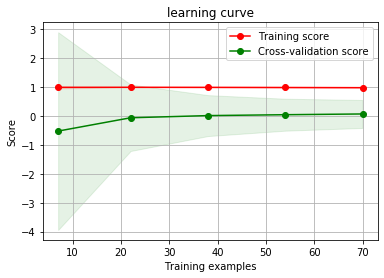

Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 0.08855178294528251
Mean Squared Error: 0.013336914187380595
Root Mean Squared Error: 0.11548555834986726
Mean Absolute Percentage Error: 13.862569697148786
R2: 0.07513530253542833


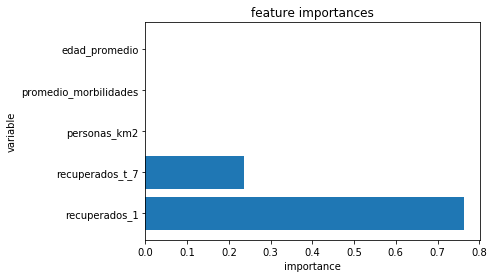

In [16]:
res_gb_r = gradientBoostingRegressor(X_r, y_r)

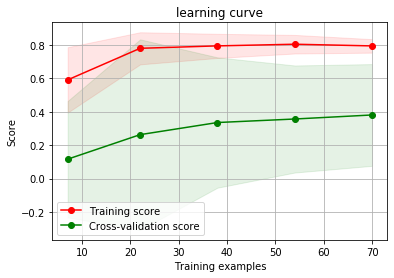

Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 0.07634502028789726
Mean Squared Error: 0.009592304648217372
Root Mean Squared Error: 0.09794031166081396
Mean Absolute Percentage Error: 13.317979078258912
R2: 0.3348098509281954


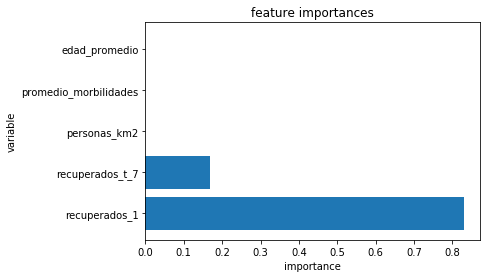

In [17]:
res_rf_r = randomForestRegressor(X_r, y_r)

## Decesos

In [18]:
X_d = df[['decesos_t_1', 'decesos_t_7', 'personas_km2', 'promedio_morbilidades', 'edad_promedio']]
y_d = df['decesos']

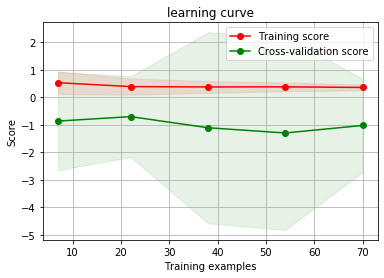

Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 0.07632805002281469
Mean Squared Error: 0.0086257365610442
Root Mean Squared Error: 0.09287484353173468
Mean Absolute Percentage Error: 4.474596719590842
R2: -0.07618269830009017


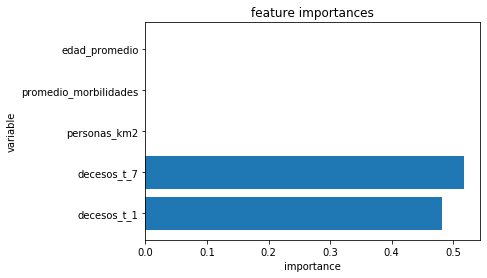

In [19]:
res_gb_d = gradientBoostingRegressor(X_d, y_d)

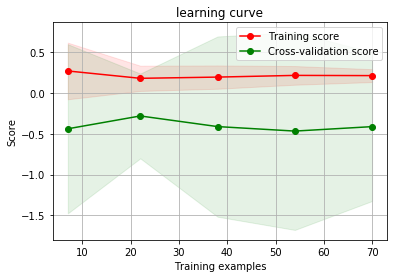

Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 0.07582406884241875
Mean Squared Error: 0.008639940781165758
Root Mean Squared Error: 0.09295128176182273
Mean Absolute Percentage Error: 4.430204522038334
R2: -0.07795487576336924


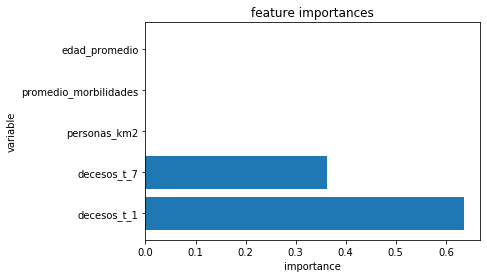

In [20]:
res_rf_d = randomForestRegressor(X_d, y_d)

## ------------------------------------------------------------------

In [21]:
from sklearn.neural_network import MLPRegressor

def mLPRegressor(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    mlp = MLPRegressor(activation='relu', solver='lbfgs', verbose=True)
    mlp.fit(X_train, y_train)
    predicts = mlp.predict(X_test)
    acc = mlp.score(X_test, y_test)
    mse = mean_squared_error(y_test, predicts)
    print("Accuracy: ", acc)
    print("MSE: ", mse)
    print("---------------------------------------")
    #print(predicts.tolist())
    return mlp
#mLPRegressor(X, y)

In [22]:
from sklearn.svm import SVR

def sVR(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    svr = SVR(gamma=0.2)
    svr.fit(X_train, y_train)
    predicts = svr.predict(X_test)
    acc = svr.score(X_test, y_test)
    mse = mean_squared_error(y_test, predicts)
    print("Accuracy: ", acc)
    print("MSE: ", mse)
    print("---------------------------------------")
    #print(predicts.tolist())
    return svr
#sVR(X, y)

In [23]:
from sklearn.neighbors import KNeighborsRegressor

def kNRegressor(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    neigh = KNeighborsRegressor(n_neighbors=15)
    neigh.fit(X_train, y_train) 
    predicts = neigh.predict(X_test)
    acc = neigh.score(X_test, y_test)
    mse = mean_squared_error(y_test, predicts)
    print("Accuracy: ", acc)
    print("MSE: ", mse)
    print("---------------------------------------")
    #print(predicts.tolist())
    return neigh
#kNRegressor(X, y)